In [1]:
#Linear Regression Models
#Chapter 3
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sin(x):
    return np.sin(2*np.pi*x)

def gauss_basis(x,mu,s):
    n = np.power(x-mu,2)
    d = 2*np.power(s,2)
    f = float(n)/d
    return np.exp(-f)

#returns wegihts based on zero mean gaussian
def get_weights(numb):
    return np.random.normal(0,.5,numb)

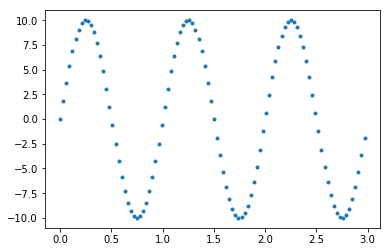

In [22]:
x = np.arange(0,3,.03)
np.random.shuffle(x)
y = 10*sin(x)
pts = np.stack((x,y),axis=1)

x = pts[:,0]
plt.plot(x,pts[:,1],'.')
plt.show()